In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Note EWKino_CLs_train.csv and EWKino_CLs_test.csv are already normalised to mean=0 and std=1 on every column that isn't CLs
df = pd.read_csv("../csv-files/EWKino_normalised_inputs_train.csv")
input_parameters = ["M_1", "M_2", "mu", "tan_beta", "M_3", "At", "Ab", "Atau", "mA", "mqL3", "mtR", "mbR"]

CLs_labels = ['FullHad', '1Lbb', '2L0J', '2L2J', 'Compressed', '3LOffshell', '3LOnshell', '4L', 'DisappearingTrack', 'h_to_inv', 'mA']
CLs_labels = [label+'__ObsCLs' for label in CLs_labels]
CLs_labels.append("Final__CLs")
chosen_CLs = CLs_labels[-1]

training_cols = input_parameters
training_cols.append(chosen_CLs)

train = df[training_cols]

In [56]:
def neg_linear_loss(y_true, y_pred):

    # Calculate absolute error for each prediction
    abs_error = tf.abs(y_true - y_pred)
    
    # Weight to focus on values close to zero
    weighted_error = abs_error * (1 + (1 - y_true))

    # Return weighted MAE as loss
    loss = tf.reduce_mean(weighted_error)
    return loss

def build_model(): # Returns a compiled model, as K-fold cross validation involves building the same model lots of times
    
    model = keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(0.005),
        loss='binary_crossentropy',
        metrics=["mae"]
    )
    
    return model

In [57]:
def k_fold_validation(k, num_epochs, df): # Trains model for one round of k-fold validation
    
    # Shuffle the entire training dataset
    shuffled_df = df.sample(frac=1)
    
    # Separate the inputs and target outputs into train and labels respectively
    labels = shuffled_df.pop(chosen_CLs)
    train = shuffled_df
    num_val_samples = len(train) // k
    if k == 1:
        num_val_samples = len(train) // 5
    all_histories = []
    
    for i in range(k):
        # print(f"Processing fold #{i}")
        
        val_data = train[i * num_val_samples: (i + 1) * num_val_samples]
        val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate(
            [train[:i * num_val_samples],
            train[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        partial_train_labels = np.concatenate(
            [labels[:i * num_val_samples],
            labels[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        model = build_model()
        
        history = model.fit(
            partial_train_data,
            partial_train_labels,
            epochs=num_epochs,
            validation_data=(val_data, val_labels),
            verbose=0
        )
        
        all_histories.append(history)
        
    # Average the training and validation accuracy for each epoch across the folds
    single_iter_val_accuracy = np.empty((k,num_epochs))
    single_iter_train_accuracy = np.empty((k,num_epochs))
    for i in range(k):
        single_iter_val_accuracy[i,:] = all_histories[i].history["val_mae"]
        single_iter_train_accuracy[i,:] = all_histories[i].history["mae"]
    single_iter_val_accuracy = single_iter_val_accuracy.mean(axis=0)
    single_iter_train_accuracy = single_iter_train_accuracy.mean(axis=0)
    
    return single_iter_val_accuracy, single_iter_train_accuracy

In [58]:
# Choose number of folds for k-fold validation, number of epochs, and iterations
k = 1
num_epochs = 400 # When testing new models, set this high enough to see overfitting (assuming model is powerful enough to overfit)
iterations = 1 # If accuracy scores have high variance, increase iterations to 5 (smoother) or 10 (smoothest)

# avg_train_accuracy and avg_val_accuracy store the training and validation accuracy for each epoch, averaged over the k folds
avg_train_accuracy = np.empty((iterations,num_epochs))
avg_val_accuracy = np.empty((iterations,num_epochs))

for i in range(iterations):
    #print(f"Processing iteration #{i}")
    single_iter_val_accuracy, single_iter_train_accuracy = k_fold_validation(k, num_epochs, train)
    avg_val_accuracy[i,:] = single_iter_val_accuracy
    avg_train_accuracy[i,:] = single_iter_train_accuracy
avg_val_accuracy = avg_val_accuracy.mean(axis=0)
avg_train_accuracy = avg_train_accuracy.mean(axis=0)

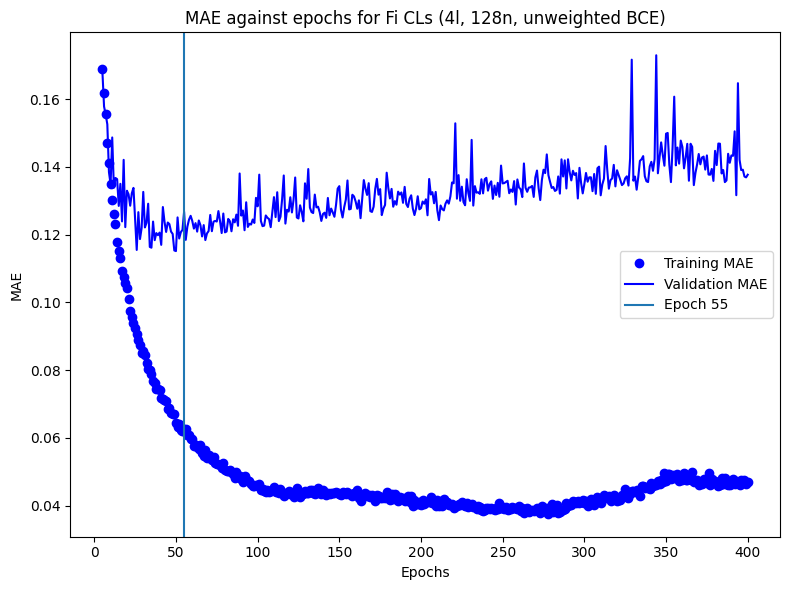

In [69]:
# Plot training and validation accuracy for each epoch

best_epoch = 55
cut = 4
epochs = range(cut+1, num_epochs + 1)
plt.figure(figsize=(8,6))
plt.plot(epochs, avg_train_accuracy[cut:], "bo", label="Training MAE")
plt.plot(epochs, avg_val_accuracy[cut:], "b", label="Validation MAE")
plt.axvline(best_epoch, label=f"Epoch {best_epoch}")
#plt.axhline(0.1115)
plt.title(f"MAE against epochs for {chosen_CLs[:-8]} CLs (4l, 128n, unweighted BCE)")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
#plt.savefig(f"../plots/fitting_different_CLs/training_info_{chosen_CLs[:-8]}.png")
plt.show()

In [39]:
# Train new model on all of the available data

df = pd.read_csv("../csv-files/EWKino_normalised_inputs_train.csv")
labels = df.pop(chosen_CLs)
train = df[training_cols[:-1]]

model = build_model()

history = model.fit(
    train,
    labels,
    epochs=best_epoch, # Change this depending on when the model starts overfitting
    verbose=0
)

In [40]:
"""
This is the code block for storing predictions and targets alone in separate dataframe
# Read in the test file that the model has not seen
test = pd.read_csv("csv-files/EWKino_Is_Valid_test.csv")

# Store the ground truth we are hoping to predict in targets
targets = test.pop("Is_Valid").values

data = {'Targets': targets,
        'Predictions': predictions}
"""

# This code reads in test dataframe, use trained model to predict value of interest, and store the predicted values and original targets
test_df = pd.read_csv("../csv-files/EWKino_normalised_inputs_test.csv")
inputs = test_df[input_parameters[:-1]]

# Create copy so we are not editing original df
test_df_plus_predictions = test_df.copy()

#model = tf.keras.models.load_model("neg_lin_loss_model.keras", compile=False)
#model.compile(optimizer=keras.optimizers.RMSprop(0.005), loss=neg_linear_loss, metrics=["mae"])

# Predict the DM relic densities using our model. Using .flatten() turns predictions into a 1D array that can be put into a dataframe
predictions = model.predict(inputs).flatten()
targets = test_df[chosen_CLs]
test_df_plus_predictions["Predicted_CLs"] = predictions

# Save the predictions of the model
#test_plus_predictions.to_csv("test_neg_lin_loss.csv", index=False)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/tmp/ipykernel_334165/1962360391.py:34: RuntimeWarning: invalid value encountered in divide
  ratio = total_rejections / incorrect_rejections


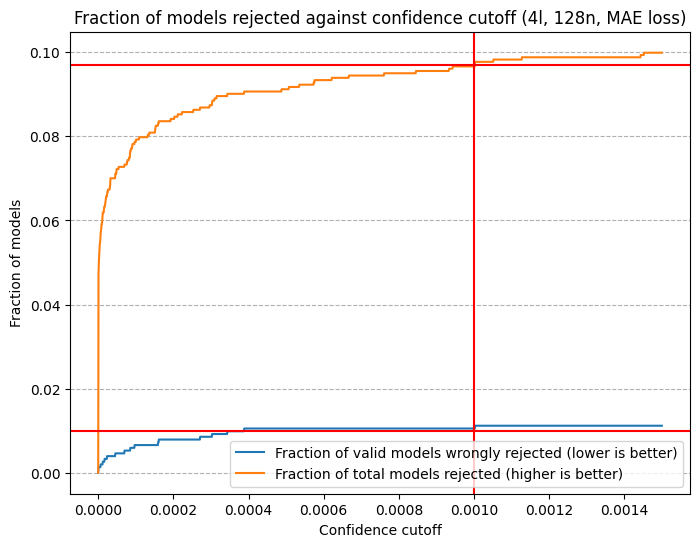

In [84]:
def plot_rejections_by_cutoff(true_values, predicted_values, num_points=100, x_range=1, save=False):

    # Calculate which models should be rejected (CLs < 0.05, which also selects Is_Valid == 0)
    true_cutoff = 0.05
    target_rejections = true_values < true_cutoff
    correct_accepted = np.logical_not(target_rejections)
    
    # Create array of test cutoffs
    test_cutoffs = np.linspace(0,x_range,num=num_points)
 
    # Create array of incorrect rejection
    incorrect_rejections = []
    total_rejections = []
    ratio = []

    for cutoff in test_cutoffs:

        # Calculate which predictions are rejected by chosen cutoff
        rejected_predictions = predicted_values < cutoff
        
        # Calculate fraction of models that should have been accepted but were rejected
        total_wrongly_rejected = (rejected_predictions > target_rejections).sum()
        fraction_wrongly_rejected = total_wrongly_rejected / correct_accepted.sum()
        
        # Calculate fraction of all models rejected
        fraction_rejeceted = rejected_predictions.sum() / len(true_values)
        
        # Store these values for plotting
        incorrect_rejections.append(fraction_wrongly_rejected)
        total_rejections.append(fraction_rejeceted)
        
    incorrect_rejections = np.array(incorrect_rejections)
    total_rejections = np.array(total_rejections)
    ratio = total_rejections / incorrect_rejections
    ratio = ratio / 400
    
    # Plot fraction of rejected models against cutoff
    plt.figure(figsize=(8, 6))
    plt.plot(test_cutoffs, incorrect_rejections)
    plt.plot(test_cutoffs, total_rejections)
    
    #plt.plot(test_cutoffs, ratio)
    
    plt.axhline(0.01, color="red")
    plt.axhline(0.097, color="red")
    plt.axvline(0.001, color='red')
    plt.xlabel("Confidence cutoff")
    plt.ylabel("Fraction of models")
    plt.grid(axis='y', linestyle='--')
    plt.legend(["Fraction of valid models wrongly rejected (lower is better)", "Fraction of total models rejected (higher is better)"])
    plt.title("Fraction of models rejected against confidence cutoff (4l, 128n, MAE loss)")
    
    if save == True:
        plt.savefig(f"../plots/fitting_different_CLs/{chosen_CLs[:-8]}.png")
        
    plt.show()
    
plot_rejections_by_cutoff(targets, predictions, len(targets), 0.0015, save=False)